# TMDbから得られた映画情報のマルチクラス・ラベル分類

## データ準備

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

data_path = '/content/drive/MyDrive/GoogleColab/マルチラベルデータセット/output_df'

df = pd.read_csv(f'{data_path}/tmdb_movies.csv')
df

,id,title,genres,release_date,popularity,vote_average,vote_count,overview
0,364897,閃乱カグラESTIVAL VERSUS -水着だらけの前夜祭-,"28,35,16",2015-04-24,1.301,10.0,1,2月。月閃女学館の雪泉と夜桜は雪中の実践修行をし、残りの3人は部屋でダラダラしていると豪華な...
1,190147,十字路,18,1928-05-11,0.989,7.2,9,江戸の裏町でひっそりと暮らす姉弟。弟はある女をめぐり傷害事件を起こしてしまう。一方姉は借金返...
2,143,西部戦線異状なし,"18,10752",1930-10-24,11.206,7.8,457,第1次大戦がはじまってまもない、ドイツのある町。群衆の歓声に送られて、戦場へ向かう大部隊が進...
3,3063,我輩はカモである,"35,10752",1934-01-27,7.993,7.4,511,財政難のフリードニア共和国は、富豪夫人の援助を受けるため、彼女の愛人を宰相に就任させる。それ...
4,630,オズの魔法使,"12,14,10751",1954-12-25,51.605,7.6,4176,カンザスの農場でおじさん夫婦と一緒に暮らす少女ドロシーは、ある日、竜巻に家ごと上空に巻き上げ...
...,...,...,...,...,...,...,...,...
5240,744392,架空OL日記,35,2020-02-28,0.600,6.5,2,お笑い芸人のバカリズムが主演や脚本を務め、2017年に放送された連続ドラマの劇場版。原作は、...
5241,718498,あのこは貴族,18,2021-02-26,0.600,0.0,0,都会の異なる環境を生きる2人の女性が、恋愛や結婚だけではない人生を切り拓く姿を描くシスターフ...
5242,704933,仮面病棟,"80,53",2020-03-06,0.717,6.7,3,医師の速水(坂口健太郎)は、一日だけの当直医として元精神科病院に出向く。だがピエロの仮面をか...
5243,695376,水曜日が消えた,9648,2020-05-15,1.400,6.0,1,幼少期の交通事故が原因で、曜日ごとに7人の人格が入れ替わる青年は、思考や性格はバラバラだが、...


In [2]:
def count_genre_kind(x):
  return list(map(int, x.split(',')))


genres = list(set(sum(df['genres'].map(count_genre_kind).tolist(), [])))
genres.sort()
genres

[12,
 14,
 16,
 18,
 27,
 28,
 35,
 36,
 37,
 53,
 80,
 99,
 878,
 9648,
 10402,
 10749,
 10751,
 10752,
 10770]

In [3]:
def get_genre_list(x):
  x_l = list(map(int, x.split(',')))
  genre_label = [0 for i in range(len(genres))]
  for xl in x_l:
    for idx, genre in enumerate(genres):
      if xl == genre:
        genre_label[idx] = 1

  return genre_label

genre_labels = np.array(df['genres'].map(get_genre_list).tolist()).T.tolist()
for idx, genre in enumerate(genres):
  df[f'genre_{genre}'] = genre_labels[idx]

df.head()

,id,title,genres,release_date,popularity,vote_average,vote_count,overview,genre_12,genre_14,genre_16,genre_18,genre_27,genre_28,genre_35,genre_36,genre_37,genre_53,genre_80,genre_99,genre_878,genre_9648,genre_10402,genre_10749,genre_10751,genre_10752,genre_10770
0,364897,閃乱カグラESTIVAL VERSUS -水着だらけの前夜祭-,"28,35,16",2015-04-24,1.301,10.0,1,2月。月閃女学館の雪泉と夜桜は雪中の実践修行をし、残りの3人は部屋でダラダラしていると豪華な...,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
1,190147,十字路,18,1928-05-11,0.989,7.2,9,江戸の裏町でひっそりと暮らす姉弟。弟はある女をめぐり傷害事件を起こしてしまう。一方姉は借金返...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,143,西部戦線異状なし,"18,10752",1930-10-24,11.206,7.8,457,第1次大戦がはじまってまもない、ドイツのある町。群衆の歓声に送られて、戦場へ向かう大部隊が進...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,3063,我輩はカモである,"35,10752",1934-01-27,7.993,7.4,511,財政難のフリードニア共和国は、富豪夫人の援助を受けるため、彼女の愛人を宰相に就任させる。それ...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
4,630,オズの魔法使,"12,14,10751",1954-12-25,51.605,7.6,4176,カンザスの農場でおじさん夫婦と一緒に暮らす少女ドロシーは、ある日、竜巻に家ごと上空に巻き上げ...,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


## マルチクラス分類

### 前処理

In [4]:
# マルチクラス用のdfを違うオブジェクトで生成し、必要な列のみ抽出
mclass_df = df.copy()[['title', 'genres', 'overview']]
mclass_df.head()

,title,genres,overview
0,閃乱カグラESTIVAL VERSUS -水着だらけの前夜祭-,"28,35,16",2月。月閃女学館の雪泉と夜桜は雪中の実践修行をし、残りの3人は部屋でダラダラしていると豪華な...
1,十字路,18,江戸の裏町でひっそりと暮らす姉弟。弟はある女をめぐり傷害事件を起こしてしまう。一方姉は借金返...
2,西部戦線異状なし,"18,10752",第1次大戦がはじまってまもない、ドイツのある町。群衆の歓声に送られて、戦場へ向かう大部隊が進...
3,我輩はカモである,"35,10752",財政難のフリードニア共和国は、富豪夫人の援助を受けるため、彼女の愛人を宰相に就任させる。それ...
4,オズの魔法使,"12,14,10751",カンザスの農場でおじさん夫婦と一緒に暮らす少女ドロシーは、ある日、竜巻に家ごと上空に巻き上げ...


In [5]:
# genresの先頭を予測対象とする
def set_target(x):
  return int(x.split(',')[0])

# ジャンルの予測対象をセット
mclass_df['target'] = mclass_df['genres'].map(set_target)
# 必要な情報のみにそぎ落とし、全てのカラムを大文字化
mclass_df = mclass_df[['title', 'overview', 'target']].rename(columns=str.upper)
mclass_df.head()

,TITLE,OVERVIEW,TARGET
0,閃乱カグラESTIVAL VERSUS -水着だらけの前夜祭-,2月。月閃女学館の雪泉と夜桜は雪中の実践修行をし、残りの3人は部屋でダラダラしていると豪華な...,28
1,十字路,江戸の裏町でひっそりと暮らす姉弟。弟はある女をめぐり傷害事件を起こしてしまう。一方姉は借金返...,18
2,西部戦線異状なし,第1次大戦がはじまってまもない、ドイツのある町。群衆の歓声に送られて、戦場へ向かう大部隊が進...,18
3,我輩はカモである,財政難のフリードニア共和国は、富豪夫人の援助を受けるため、彼女の愛人を宰相に就任させる。それ...,35
4,オズの魔法使,カンザスの農場でおじさん夫婦と一緒に暮らす少女ドロシーは、ある日、竜巻に家ごと上空に巻き上げ...,12


In [6]:
import re
import string

# テキストの前処理
def preprocessing(text):
  # 全角 => 半角
  text = text.translate(str.maketrans({chr(0xFF01 + i): chr(0x21 + i) for i in range(94)}))
  # 英語大文字を小文字化
  text = text.lower()
  # 記号をスペースに置換後、スペースを削除
  table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
  text = ''.join(text.translate(table).split())
  # 削除する文字列
  remove_list = ['\n', '　', ' ']
  for rem_word in remove_list:
    text = text.replace(rem_word, '')
  # 数字列を0に置換
  text = re.sub('[0-9]+', '0', text)

  return text

In [7]:
mclass_df['OVERVIEW'] += mclass_df['TITLE']
mclass_df['OVERVIEW'] = mclass_df['OVERVIEW'].map(preprocessing)
mclass_df.head()

,TITLE,OVERVIEW,TARGET
0,閃乱カグラESTIVAL VERSUS -水着だらけの前夜祭-,0月。月閃女学館の雪泉と夜桜は雪中の実践修行をし、残りの0人は部屋でダラダラしていると豪華な...,28
1,十字路,江戸の裏町でひっそりと暮らす姉弟。弟はある女をめぐり傷害事件を起こしてしまう。一方姉は借金返...,18
2,西部戦線異状なし,第0次大戦がはじまってまもない、ドイツのある町。群衆の歓声に送られて、戦場へ向かう大部隊が進...,18
3,我輩はカモである,財政難のフリードニア共和国は、富豪夫人の援助を受けるため、彼女の愛人を宰相に就任させる。それ...,35
4,オズの魔法使,カンザスの農場でおじさん夫婦と一緒に暮らす少女ドロシーは、ある日、竜巻に家ごと上空に巻き上げ...,12


### Mecabインストール

In [ ]:
!apt install aptitude
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
!pip install mecab-python3==0.7

!git clone --depth 1 https://github.com/neologd/mecab-ipadic-neologd.git
!echo yes | mecab-ipadic-neologd/bin/install-mecab-ipadic-neologd -n

!sed -e "s!/var/lib/mecab/dic/debian!/usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ipadic-neologd!g" /etc/mecabrc &gt; /etc/mecabrc.new
!cp /etc/mecabrc /etc/mecabrc.org
!cp /etc/mecabrc.new /etc/mecabrc

### 分かち書き

In [9]:
import MeCab

stop_words = ['0']
neologd = '-d /usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ipadic-neologd'

# デフォルト辞書はNEologd
def tokenize(text, dictionary=neologd, target_pos=list(('名詞', '形容詞', '形容動詞', '動詞', '副詞'))):
  tokens = []
  mecab = MeCab.Tagger(dictionary)
  mecab.parse('') #文字列がGCされるのを防ぐ
  node = mecab.parseToNode(text)
  while node:
    #単語を取得
    word = node.surface
    #品詞を取得
    pos = node.feature.split(',')[0]
    # target_posの場合 と　stop_wordsにない単語のみ抽出
    if pos in target_pos and word not in stop_words:
      tokens.append(word)
    #次の単語に進める
    node = node.next
  return tokens

print('NEologd:', tokenize('ショーシャンクの空に'))
print('default:', tokenize('ショーシャンクの空に', ''))

NEologd: ['ショーシャンクの空に']
default: ['ショーシャンク', '空']


In [10]:
mclass_df['TITLE_WAKATI'] = mclass_df['TITLE'].map(lambda x: ' '.join(tokenize(x, '')))
mclass_df['OVERVIEW_WAKATI'] = mclass_df['OVERVIEW'].map(lambda x: ' '.join(tokenize(x)))
mclass_df.head()

,TITLE,OVERVIEW,TARGET,TITLE_WAKATI,OVERVIEW_WAKATI
0,閃乱カグラESTIVAL VERSUS -水着だらけの前夜祭-,0月。月閃女学館の雪泉と夜桜は雪中の実践修行をし、残りの0人は部屋でダラダラしていると豪華な...,28,閃乱 カグラ ESTIVAL VERSUS - 水着 だらけ 前夜祭 -,月 月 閃 女 学 館 雪 泉 夜桜 雪 中 実践 修行 し 残り 人 部屋 ダラダラ し ...
1,十字路,江戸の裏町でひっそりと暮らす姉弟。弟はある女をめぐり傷害事件を起こしてしまう。一方姉は借金返...,18,十字路,江戸 裏町 ひっそり 暮らす 姉弟 弟 ある 女 めぐり 傷害事件 起こし しまう 姉 借金...
2,西部戦線異状なし,第0次大戦がはじまってまもない、ドイツのある町。群衆の歓声に送られて、戦場へ向かう大部隊が進...,18,西部 戦線 異状 なし,次 大戦 はじ てま ない ドイツ ある 町 群衆 歓声 送ら れ 戦場 向かう 部隊 進軍...
3,我輩はカモである,財政難のフリードニア共和国は、富豪夫人の援助を受けるため、彼女の愛人を宰相に就任させる。それ...,35,我輩 カモ,財政難 フリードニア 共和国 富豪 夫人 援助 受ける ため 彼女 愛人 宰相 就任 さ せ...
4,オズの魔法使,カンザスの農場でおじさん夫婦と一緒に暮らす少女ドロシーは、ある日、竜巻に家ごと上空に巻き上げ...,12,オズ 魔法使,カンザス 農場 おじさん 夫婦 一緒 暮らす 少女 ドロシー ある日 竜巻 家 ごと 上空 ...


In [11]:
mclass_df['FEATURE'] = mclass_df['TITLE_WAKATI'] + ' ' + mclass_df['OVERVIEW_WAKATI']
mclass_df.head()

,TITLE,OVERVIEW,TARGET,TITLE_WAKATI,OVERVIEW_WAKATI,FEATURE
0,閃乱カグラESTIVAL VERSUS -水着だらけの前夜祭-,0月。月閃女学館の雪泉と夜桜は雪中の実践修行をし、残りの0人は部屋でダラダラしていると豪華な...,28,閃乱 カグラ ESTIVAL VERSUS - 水着 だらけ 前夜祭 -,月 月 閃 女 学 館 雪 泉 夜桜 雪 中 実践 修行 し 残り 人 部屋 ダラダラ し ...,閃乱 カグラ ESTIVAL VERSUS - 水着 だらけ 前夜祭 - 月 月 閃 女 学...
1,十字路,江戸の裏町でひっそりと暮らす姉弟。弟はある女をめぐり傷害事件を起こしてしまう。一方姉は借金返...,18,十字路,江戸 裏町 ひっそり 暮らす 姉弟 弟 ある 女 めぐり 傷害事件 起こし しまう 姉 借金...,十字路 江戸 裏町 ひっそり 暮らす 姉弟 弟 ある 女 めぐり 傷害事件 起こし しまう ...
2,西部戦線異状なし,第0次大戦がはじまってまもない、ドイツのある町。群衆の歓声に送られて、戦場へ向かう大部隊が進...,18,西部 戦線 異状 なし,次 大戦 はじ てま ない ドイツ ある 町 群衆 歓声 送ら れ 戦場 向かう 部隊 進軍...,西部 戦線 異状 なし 次 大戦 はじ てま ない ドイツ ある 町 群衆 歓声 送ら れ ...
3,我輩はカモである,財政難のフリードニア共和国は、富豪夫人の援助を受けるため、彼女の愛人を宰相に就任させる。それ...,35,我輩 カモ,財政難 フリードニア 共和国 富豪 夫人 援助 受ける ため 彼女 愛人 宰相 就任 さ せ...,我輩 カモ 財政難 フリードニア 共和国 富豪 夫人 援助 受ける ため 彼女 愛人 宰相 ...
4,オズの魔法使,カンザスの農場でおじさん夫婦と一緒に暮らす少女ドロシーは、ある日、竜巻に家ごと上空に巻き上げ...,12,オズ 魔法使,カンザス 農場 おじさん 夫婦 一緒 暮らす 少女 ドロシー ある日 竜巻 家 ごと 上空 ...,オズ 魔法使 カンザス 農場 おじさん 夫婦 一緒 暮らす 少女 ドロシー ある日 竜巻 家...


### 目的変数の作成

In [68]:
# GENREコードをそのまま使用
Y = np.array(mclass_df['TARGET'])
Y

array([  28,   18,   18, ...,   80, 9648,   16])

In [69]:
# GENREコードを固有のIDへ変換
genre2id = {}
for idx, genre in enumerate(genres):
  genre2id[genre] = idx
Y = np.array(pd.Series(Y).map(genre2id))
Y

array([ 5,  3,  3, ..., 10, 13,  2])

### 単語埋め込みのためのベクトライザー作成やロード

In [14]:
import string

def transform_w2v(text, vec):
  vec_size = vec['映画'].shape[0]
  table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
  words = text.translate(table).split()  # 記号をスペースに置換後、スペースで分割してリスト化
  vecs = [vec[word] for word in words if word in vec]  # 1語ずつベクトル化

  if len(vecs) != 0:
    # 各単語の平均ベクトルを出力
    return np.array(sum(vecs) / len(vecs))
  else:
    # 単語が全てvecになかったら、0ベクトルを出力
    return np.array(np.zeros(vec_size))

#### Word2Vec（独自学習）

In [15]:
sentences = [s.split() for s in mclass_df['FEATURE'].tolist()]
sentences[:2]

[['閃乱',
  'カグラ',
  'ESTIVAL',
  'VERSUS',
  '-',
  '水着',
  'だらけ',
  '前夜祭',
  '-',
  '月',
  '月',
  '閃',
  '女',
  '学',
  '館',
  '雪',
  '泉',
  '夜桜',
  '雪',
  '中',
  '実践',
  '修行',
  'し',
  '残り',
  '人',
  '部屋',
  'ダラダラ',
  'し',
  'いる',
  '豪華',
  'スパリゾート',
  '人',
  '分',
  '招待',
  '状',
  '届い',
  '早速',
  '行こう',
  '盛り上がる',
  '修行',
  '帰っ',
  'き',
  '雪',
  '泉',
  'ダメ',
  '言い',
  'ダラ',
  'いる',
  '指摘',
  'する',
  '様々',
  '意見',
  '飛び交い',
  'ぱいじゃんけんだよで',
  '四季',
  '勝ち',
  'プール',
  '行く',
  'こと',
  'なっ',
  'プール',
  '半蔵',
  '学院',
  '焔',
  '紅蓮',
  '隊',
  '蛇',
  '女子',
  '学園',
  '面々',
  'やって来',
  'い',
  '今日',
  '楽しも',
  'こと',
  'なり',
  '一時',
  '休戦',
  '状態',
  '些細なこと',
  '不毛',
  '言い争い',
  'なり',
  '雪',
  '泉',
  '提案',
  '古来より',
  '忍び',
  '決闘',
  '法',
  '忍',
  '騎馬戦',
  '雌雄を決する',
  '事',
  'なる',
  '閃乱カグラ',
  'estivalversus',
  '水着',
  'だらけ',
  '前夜祭'],
 ['十字路',
  '江戸',
  '裏町',
  'ひっそり',
  '暮らす',
  '姉弟',
  '弟',
  'ある',
  '女',
  'めぐり',
  '傷害事件',
  '起こし',
  'しまう',
  '姉',
  '借金',
  '返済',
  '身売り',
  '話',
  '持ちかけ',
  'ら

In [ ]:
from gensim.models import word2vec
import logging

vec_size = 64
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
vectorizer = word2vec.Word2Vec(sentences,
                               sg=1,            # Skip-gram
                               size=vec_size,   # 次元数
                               min_count=5,     # min_count回未満の単語を破棄
                               window=3,        # 文脈の最大単語数
                               hs=0,            # 階層ソフトマックス(ネガティブサンプリングするなら0)
                               negative=5,      # ネガティブサンプリング
                               iter=50          # Epoch数
                               )

In [ ]:
vectorizer.most_similar('映画')

In [ ]:
vectorizer['映画'].shape[0]

#### Word2Vec（ChiVe）

In [ ]:
import gensim
import urllib.request
import sys

#ダウンロード
url = "https://sudachi.s3-ap-northeast-1.amazonaws.com/chive/chive-1.2-mc90_gensim.tar.gz"  #ファイルのURLを指定
urllib.request.urlretrieve(url,"chive.tar.gz")
#解凍
!tar -zxvf chive.tar.gz

vectorizer = gensim.models.KeyedVectors.load("chive-1.2-mc90_gensim/chive-1.2-mc90.kv")

chive-1.2-mc90_gensim/
chive-1.2-mc90_gensim/chive-1.2-mc90.kv
chive-1.2-mc90_gensim/chive-1.2-mc90.kv.vectors.npy
chive-1.2-mc90_gensim/LICENSE
chive-1.2-mc90_gensim/README.md


2021-07-12 13:45:24,025 : INFO : loading Word2VecKeyedVectors object from chive-1.2-mc90_gensim/chive-1.2-mc90.kv
2021-07-12 13:45:26,113 : INFO : loading vectors from chive-1.2-mc90_gensim/chive-1.2-mc90.kv.vectors.npy with mmap=None
2021-07-12 13:45:26,349 : INFO : setting ignored attribute vectors_norm to None
2021-07-12 13:45:26,353 : INFO : loaded chive-1.2-mc90_gensim/chive-1.2-mc90.kv


In [ ]:
vectorizer.most_similar('映画')

2021-07-12 13:46:10,365 : INFO : precomputing L2-norms of word weight vectors


[('邦画', 0.7711033821105957),
 ('予告編', 0.7660966515541077),
 ('主演', 0.7257440090179443),
 ('ハリウッド', 0.7001019716262817),
 ('映画館', 0.6935902237892151),
 ('映画界', 0.689943253993988),
 ('劇映画', 0.6886698007583618),
 ('話題作', 0.684718132019043),
 ('映画化', 0.681873083114624),
 ('上映', 0.6801760196685791)]

In [ ]:
vectorizer['映画'].shape[0]

300

#### TF-IDF（独自学習）

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_tfidf = TfidfVectorizer(tokenizer=tokenize,
                                   ngram_range=(1, 1),
                                   min_df=5)
vectors = vectorizer_tfidf.fit_transform(mclass_df['OVERVIEW'])
vectors.shape

(5245, 306313)

### 説明変数の作成

In [70]:
X = np.array([transform_w2v(text, vectorizer) for text in mclass_df['FEATURE']])

print('== Word2Vec ==')
print('独自学習:', X.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


== Word2Vec ==
独自学習: (5245, 64)


### 学習・検証・評価に分割

In [71]:
from sklearn.model_selection import train_test_split

# 独自学習のWord2Vec
X_train, X_valid_test, y_train, y_valid_test = train_test_split(X, Y, train_size=0.8, random_state=144, stratify=Y)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid_test, y_valid_test, train_size=0.5, random_state=144)

print(f'{"="*20} 学習データ {"="*20}')
print('X:', X_train.shape)
print('Y:', y_train.shape)
print(f'{"="*20} 検証データ {"="*20}')
print('X:', X_valid.shape)
print('Y:', y_valid.shape)
print(f'{"="*20} 評価データ {"="*20}')
print('X:', X_test.shape)
print('Y:', y_test.shape)

==================== 学習データ ====================
X: (4196, 64)
Y: (4196,)
==================== 検証データ ====================
X: (524, 64)
Y: (524,)
==================== 評価データ ====================
X: (525, 64)
Y: (525,)


### 学習・予測・精度評価

#### メソッド

In [21]:
def print_true_pred(y_true, y_pred, text, limited_num=20):
  print(f'{"="*36} {text} {"="*36}')
  print('検証正解：', y_true[:limited_num])
  print('検証予測：', y_pred[:limited_num])

In [73]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report

def learn_pred_accuracy(clf, train_x, train_y, valid_x, valid_y, test_x, test_y):
  # 学習
  clf.fit(train_x, train_y)
  # 予測
  predict_vy = clf.predict(valid_x)
  predict_y = clf.predict(test_x)
  # 正解率
  print('検証True:', np.count_nonzero(predict_vy == valid_y))
  print('検証False:', np.count_nonzero(predict_vy != valid_y))
  print('検証正解率:', np.count_nonzero(predict_vy == valid_y) / len(valid_y))
  print('テストTrue:', np.count_nonzero(predict_y == test_y))
  print('テストFalse:', np.count_nonzero(predict_y != test_y))
  print('テスト正解率:', np.count_nonzero(predict_y == test_y) / len(test_y))
  # 様々な精度結果
  print(classification_report(test_y, predict_y))
  # 正解と予測データ
  print('検証正解：', valid_y[:20])
  print('検証予測：', predict_vy[:20])
  print('test正解：', test_y[:20])
  print('test予測：', predict_y[:20])
  # DF化
  ## valid
  pred_df = pd.DataFrame({'data': predict_vy, 'type': 'pred'})
  true_df = pd.DataFrame({'data': valid_y, 'type': 'true'})
  valid_df = pd.concat([true_df, pred_df]).reset_index(drop=True)
  ## test
  pred_df = pd.DataFrame({'data': predict_y, 'type': 'pred'})
  true_df = pd.DataFrame({'data': test_y, 'type': 'true'})
  test_df = pd.concat([true_df, pred_df]).reset_index(drop=True)
  # 予測データのヒストグラム
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
  sns.countplot(data=valid_df, x='data', hue='type', ax=ax1)
  sns.countplot(data=test_df, x='data', hue='type', ax=ax2)
  # 混合行列
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 5))
  cm = confusion_matrix(valid_y, predict_vy)
  p1 = sns.heatmap(cm, cmap='jet', annot=True, ax=ax1)
  p1.set(xlabel='predict', ylabel='true')
  cm = confusion_matrix(test_y, predict_y)
  p2 = sns.heatmap(cm, cmap='jet', annot=True, ax=ax2)
  p2.set(xlabel='predict', ylabel='true')

#### LSTM（Keras）

In [127]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers import Embedding, Dropout, Bidirectional
from keras.layers.recurrent import LSTM
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from sklearn.metrics import recall_score, precision_score, f1_score

# データを整形
def format_data(x, y, nb_of_samples, sequence_len):
    # 学習データを整形
    X_np = np.array(x)
    # 正解データを整形
    t = tf.keras.utils.to_categorical(y.reshape(y.shape[0], 1), num_classes=len(genres))
    # LSTMに与える入力のため、(サンプル, 時刻, 特徴量の次元) の3次元にする
    return X_np, t
    #return X_np.reshape((nb_of_samples, sequence_len, 1)), t


bs = 256
nhu = len(genres)
epoch = 100

input_dim = 1                             # 入力データの次元数
output_dim = len(genres)                  # 出力データの次元数
num_hidden_units = nhu                    # 隠れ層のユニット数
len_sequence = X_train.shape[1]           # 時系列の長さ
batch_size = bs                           # ミニバッチサイズ
num_of_training_epochs = epoch            # 学習エポック数
learning_rate = 0.001                     # 学習率
num_training_samples = X_train.shape[0]   # 学習データのサンプル数

X_t, t = format_data(X_train, y_train, num_training_samples, len_sequence)

# モデル構築
## index振り直し
K.clear_session()
"""
model = Sequential()
model.add(Embedding(len_sequence, output_dim=len(genres)))
model.add(Bidirectional(LSTM(
    num_hidden_units,
    input_shape=(len_sequence, input_dim),
    return_sequences=False,
    dropout=0.5,
    recurrent_dropout=0.5)))
"""

""" 重みの正則化とドロップアウト
model.add(Dense(output_dim, activation='relu',
                     kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(output_dim, activation='relu',
                     kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(Dropout(0.5))
### """
#model.add(Dense(output_dim, activation='softmax'))

model = Sequential()
model.add(Dense(input_dim=len_sequence, units=output_dim))
model.add(Activation('softmax'))


model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=learning_rate),
              metrics=['accuracy'])
model.summary()

# アーリーストッピング
#early_stopping = EarlyStopping(monitor='val_loss', mode='auto', patience=50)

# データの整形
## (サンプル, 時刻, 特徴量の次元) の3次元の入力を与える
X_valid_t, y_valid_t = format_data(X_valid, y_valid, num_training_samples, len_sequence)
X_test_t, y_test_t = format_data(X_test, y_test, num_training_samples, len_sequence)

# 学習
model.fit(
    X_t, t,
    batch_size=batch_size,
    epochs=num_of_training_epochs,
    validation_data=(X_valid_t, y_valid_t),
    #validation_split=0.1,
    #callbacks=[early_stopping]
)

# 予測
## 検証用
y_pred_vali = model.predict(X_valid_t)
## 評価用
y_pred_test = model.predict(X_test_t)

# 結果出力
print(f'{"="*36} LSTM {"="*36}')
_, y_valid_T = np.where(y_valid_t > 0)
_, y_test_T = np.where(y_test_t > 0)
y_pred_vali_T = np.argmax(y_pred_vali, axis=1)
y_pred_test_T = np.argmax(y_pred_test, axis=1)
print('検証用')
print('予測：', y_pred_vali_T[:20])
print('正解：', y_valid_T[:20])
print('評価用')
print('予測：', y_pred_test_T[:20])
print('正解：', y_test_T[:20])
average = 'macro'
# macro-F1
print(f'valid_macroF1: {f1_score(y_true=y_valid_T, y_pred=y_pred_vali_T, average=average):.4f}')
print(f'test_macroF1: {f1_score(y_true=y_test_T, y_pred=y_pred_test_T, average=average):.4f}')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 19)                1235      
_________________________________________________________________
activation (Activation)      (None, 19)                0         
Total params: 1,235
Trainable params: 1,235
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
17/17 [==============================] - 1s 15ms/step - loss: 2.9094 - accuracy: 0.0378 - val_loss: 2.7742 - val_accuracy: 0.1107
Epoch 2/100
17/17 [==============================] - 0s 3ms/step - loss: 2.7467 - accuracy: 0.1385 - val_loss: 2.6309 - val_accuracy: 0.1927
Epoch 3/100
17/17 [==============================] - 0s 3ms/step - loss: 2.6028 - accuracy: 0.2126 - val_loss: 2.5215 - val_accuracy: 0.2099
Epoch 4/100
17/17 [==============================] - 0s 3ms/step - loss: 2.4940 - accuracy: 

#### Random Forest Classifier

検証True: 211
検証False: 313
検証正解率: 0.4026717557251908
テストTrue: 211
テストFalse: 314
テスト正解率: 0.40190476190476193
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        24
           1       0.00      0.00      0.00        11
           2       0.39      0.38      0.38        74
           3       0.41      0.76      0.54       129
           4       0.00      0.00      0.00        23
           5       0.41      0.72      0.52       100
           6       0.31      0.18      0.23        61
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00        15
          10       1.00      0.05      0.10        20
          11       0.50      0.12      0.20         8
          12       0.00      0.00      0.00        14
          13       0.00      0.00      0.00        11
          14       0.00      0.00      0.00         3
          15       0.00      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


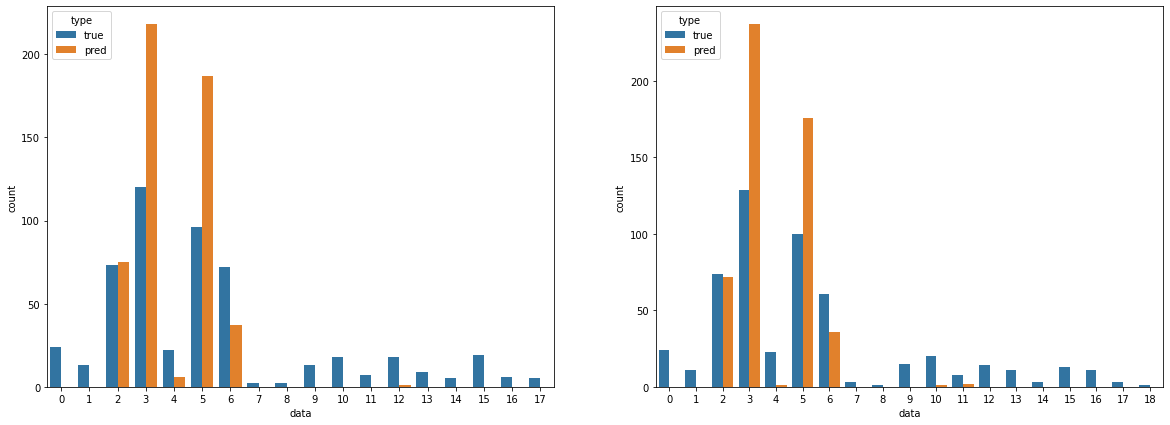

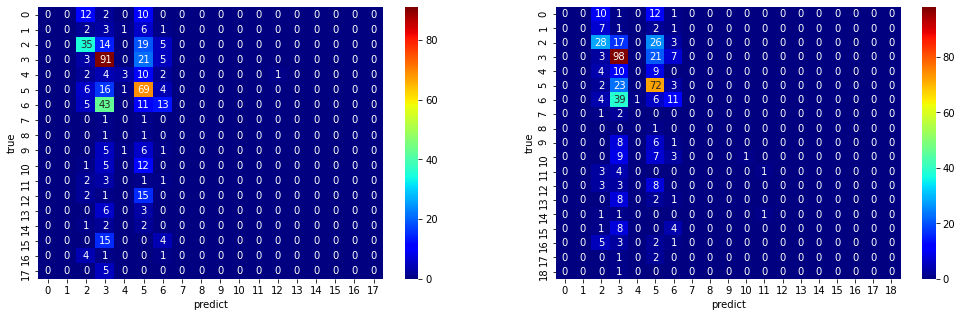

In [74]:
from sklearn.ensemble import RandomForestClassifier as classifier

# モデル定義
clf = classifier(random_state=144)
learn_pred_accuracy(clf, X_train, y_train, X_valid, y_valid, X_test, y_test)

#### Naive Bayes

検証True: 161
検証False: 363
検証正解率: 0.30725190839694655
テストTrue: 170
テストFalse: 355
テスト正解率: 0.3238095238095238
              precision    recall  f1-score   support

          12       0.00      0.00      0.00        24
          14       0.00      0.00      0.00        11
          16       1.00      0.04      0.08        74
          18       0.29      0.95      0.45       129
          27       0.00      0.00      0.00        23
          28       0.43      0.45      0.44       100
          35       0.00      0.00      0.00        61
          36       0.00      0.00      0.00         3
          37       0.00      0.00      0.00         1
          53       0.00      0.00      0.00        15
          80       0.00      0.00      0.00        20
          99       0.00      0.00      0.00         8
         878       0.00      0.00      0.00        14
        9648       0.00      0.00      0.00        11
       10402       0.00      0.00      0.00         3
       10749       0.00      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


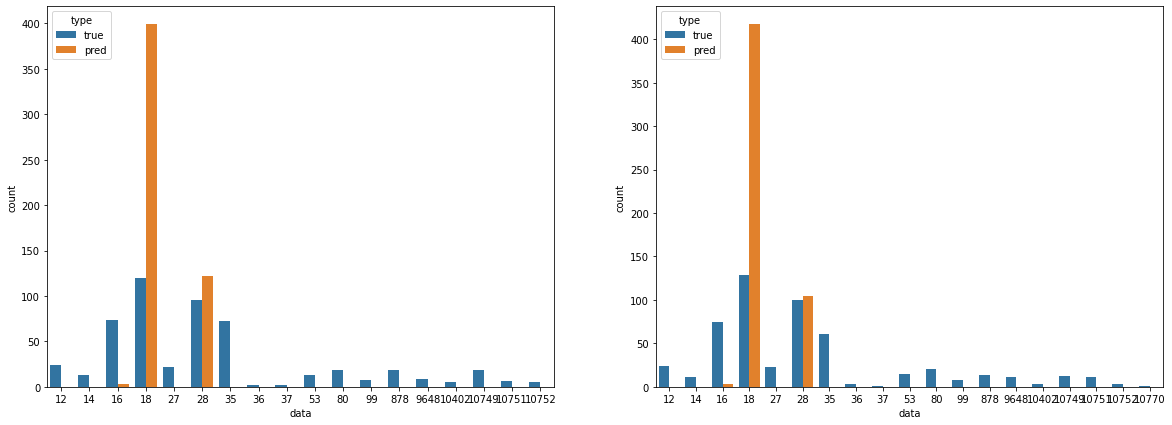

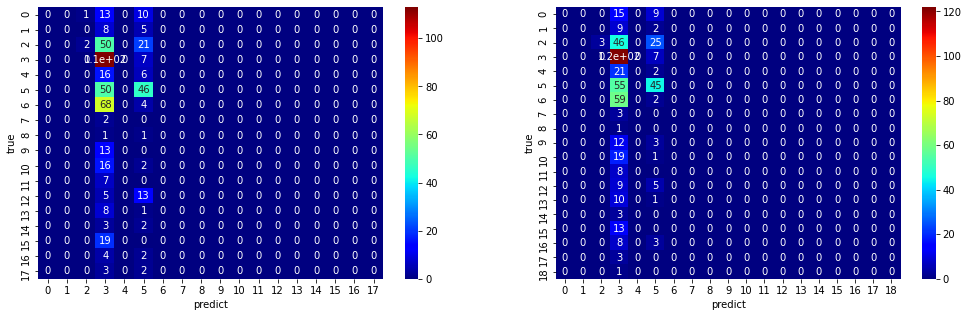

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import preprocessing

clf = MultinomialNB(alpha=.01)
mm = preprocessing.MinMaxScaler()
try:
  X_train_mm = mm.fit_transform(X_train)
except:
  X_train_mm = X_train
try:
  X_valid_mm = mm.transform(X_valid)
except:
  X_valid_mm = X_valid
try:
  X_test_mm = mm.transform(X_test)
except:
  X_test_mm = X_test
learn_pred_accuracy(clf, X_train_mm, y_train, X_valid_mm, y_valid, X_test_mm, y_test)

#### XGB

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

def predict_by_xgb():
  # DMatrixに変換
  dtrain = xgb.DMatrix(X_train, label=y_train)
  dvalid = xgb.DMatrix(X_valid, label=y_valid)
  dtest = xgb.DMatrix(X_test, label=y_test)

  # ハイパーパラメータの設定
  params = {'objective': 'multi:softmax',
            'silent': 1,
            'random_state': 144,
            'eval_metric': 'auc',
            'num_class': len(genres)}
  # 学習回数
  num_round = 500
  # アーリーストッピング
  es_round = 50

  # 訓練データはdtrain、評価用のテストデータはdvalidで設定
  watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
  # 学習
  xgb_model = xgb.train(params,
                    dtrain,
                    num_round,
                    evals=watchlist,
                    early_stopping_rounds=es_round
                    )
  # 予測
  y_pred_vali = xgb_model.predict(dvalid, ntree_limit = xgb_model.best_ntree_limit)
  y_pred_test = xgb_model.predict(dtest, ntree_limit = xgb_model.best_ntree_limit)

  # 正解データ
  valid_true = np.array(y_valid)
  test_true = np.array(y_test)
  # 結果出力
  print(f'{"="*36} XGB Classifier {"="*36}')
  print('検証用')
  print('予測：', y_pred_vali)
  print('正解：', valid_true)
  print('評価用')
  print('予測：', y_pred_test)
  print('正解：', test_true)
  print(f'valid_RMSE: {np.sqrt(mean_squared_error(valid_true, y_pred_vali)):.4f}')
  print(f'test_RMSE: {np.sqrt(mean_squared_error(test_true, y_pred_test)):.4f}')

predict_by_xgb()

検証True: 208
検証False: 316
検証正解率: 0.3969465648854962
テストTrue: 223
テストFalse: 302
テスト正解率: 0.4247619047619048
              precision    recall  f1-score   support

          12       0.00      0.00      0.00        24
          14       0.00      0.00      0.00        11
          16       0.42      0.50      0.45        74
          18       0.46      0.67      0.54       129
          27       0.20      0.09      0.12        23
          28       0.47      0.68      0.55       100
          35       0.39      0.36      0.37        61
          36       0.00      0.00      0.00         3
          37       0.00      0.00      0.00         1
          53       0.00      0.00      0.00        15
          80       0.80      0.20      0.32        20
          99       0.00      0.00      0.00         8
         878       0.14      0.07      0.10        14
        9648       0.14      0.09      0.11        11
       10402       0.00      0.00      0.00         3
       10749       0.25      0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


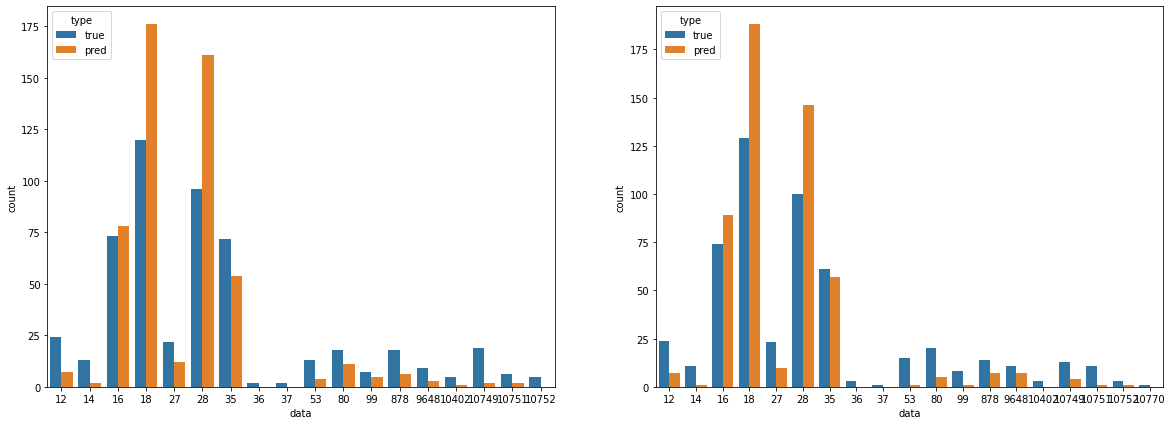

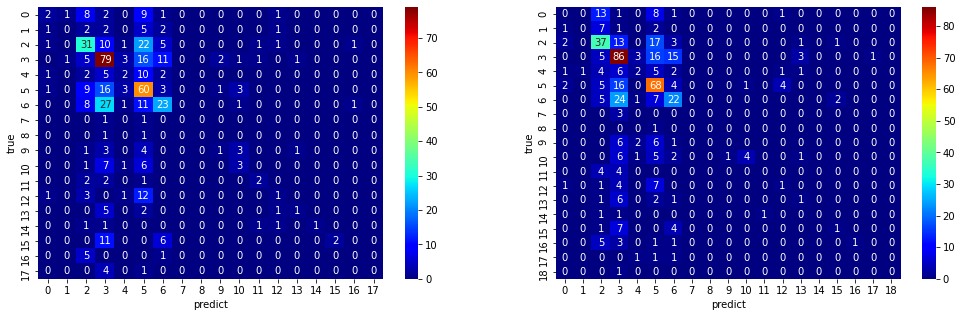

In [ ]:
from xgboost import XGBClassifier

clf = XGBClassifier(random_state=144, objective='binary:logistic')
learn_pred_accuracy(clf, X_train, y_train, X_valid, y_valid, X_test, y_test)